In [247]:
import pandas as pd
import requests
from lxml import etree
from urllib.request import urlopen
import csv
import matplotlib.pyplot as plt
import numpy as np

In [248]:
url = 'http://www.statdata.ru/largest_cities_russia'
headers = {'Content-Type': 'text/html', 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
response = requests.get(url, headers=headers) #Получение веб-страницы
html = response.text
with open ('cities.html', 'w', encoding = 'utf8') as f:
    f.write(html)
local = 'file:///C:/Users/zhash/cities.html'
response = urlopen(local)
htmlparser = etree.HTMLParser()
tree = etree.parse(response, htmlparser)

In [249]:
a = tree.xpath('//figure[@class = "wp-block-table is-style-stripes"]\
           /descendant::node()[not(contains(text(), "Город"))][not(contains(text(), "№"))]\
           [not(contains(text(), "на 1 января"))][not(contains(text(), "Динамика"))]\
           [not(contains(text(), "Процент"))][not(contains(text(), "Субъект"))]/text()')
#Исключение заголовков из таблиц

In [250]:
cities = list()
for i in range(len(a)): #Формирование списка без номеров (в таблице на сайте номера городов, начиная со 2-ой таблицы
                        #имеют 2 номера - общий и локальный, поэтому проще удалить все номера)
    if a[i][0:16] == "г. Сергиев Посад": #Пустое значение динамики на сайте
        cities.extend(a[i:i+3])
        cities.append(str(0))
        cities.extend(a[i+3:i+5])
    elif a[i][0:2] == "г.":
        cities.extend(a[i:i+6])
count = 1
cities_base = list()
cities_new = list()
for i in range(len(cities)):
    if i%6 == 0: #Добавить номер города по списку
        cities_new.append(str(count))
        count += 1
        cities_new.append(cities[i])
    if i%6 == 5: #Добавить название субъекта без удаления лишних пробелов
        cities_new.append(cities[i])
    if i%6 == 4 or i%6 == 3:
        if "—" in cities[i]: #Замена длинного тире на короткое в числовых значениях (чтобы правильно интерпретировалось питоном)
            cities[i] = cities[i].replace("—", "-")
        cities_new.append(cities[i].replace(" ", ""))
    if i%6 != 3 and i%6 != 4 and i%6 != 5 and i%6 != 0:
        cities_new.append(cities[i].replace(" ", "")) #Удаление пробелов в числовых значениях кол-ва населения
templist = list()
for i in range(len(cities_new)): #Членение массива cities_new по массивам длины 7 для корректной записи в csv
    templist.append(cities_new[i])
    if i%7 == 6:
        cities_base.append(templist)
        templist = list()

In [251]:
with open('citiesFile.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ";")
    writer.writerow(['№','City','populationOn1stJan2021', 'populationOn1stJan2020', 'Dynamics','Percent','rfSubject'])
    writer.writerows(cities_base)

df = pd.read_csv('citiesFile.csv', sep = ";", encoding='cp1251')
df.info()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   №                       172 non-null    int64 
 1   City                    172 non-null    object
 2   populationOn1stJan2021  172 non-null    int64 
 3   populationOn1stJan2020  172 non-null    int64 
 4   Dynamics                172 non-null    int64 
 5   Percent                 172 non-null    object
 6   rfSubject               172 non-null    object
dtypes: int64(4), object(3)
memory usage: 9.5+ KB


Text(0.5, 1.0, 'Население субъектов РФ')

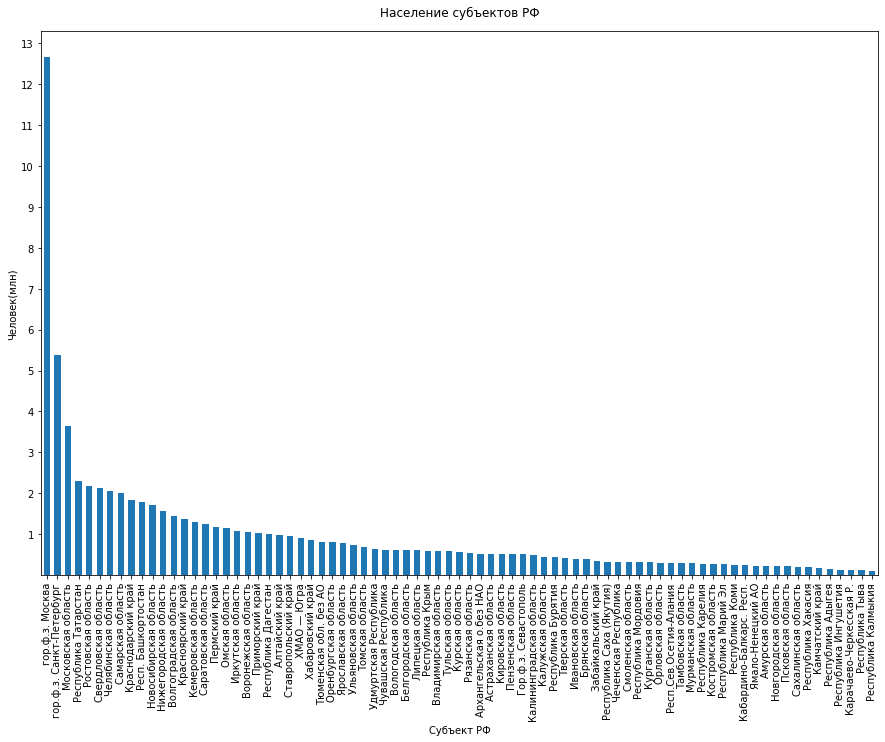

In [257]:
graph = df.groupby('rfSubject').agg('sum').sort_values('populationOn1stJan2021', ascending = False)
graph['populationOn1stJan2021'] = graph['populationOn1stJan2021']/1000000
z = graph['populationOn1stJan2021'].plot.bar(figsize = (15, 10), width = 0.6)
plt.yticks([i for i in range(1, 14)])
z.set_ylabel('Человек(млн)')
z.set_xlabel('Субъект РФ')
z.set_title(loc = 'center', pad = 15, label = 'Население субъектов РФ')

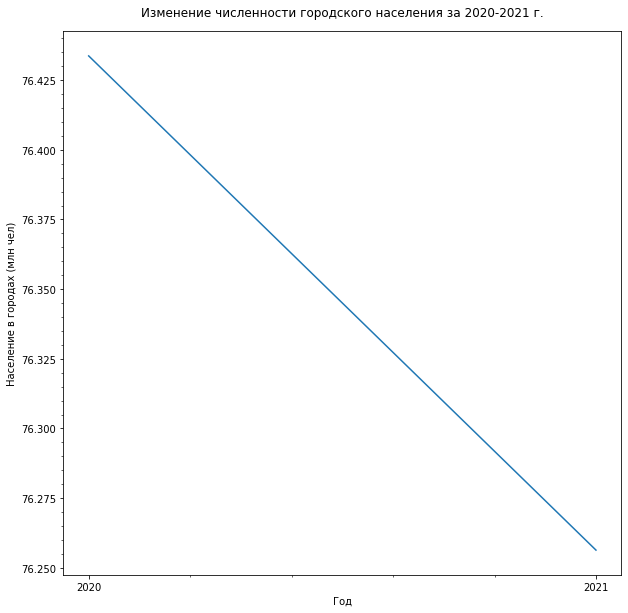

In [253]:
x = [2020, 2021]
y = [df['populationOn1stJan2020'].agg('sum')/1000000, df['populationOn1stJan2021'].agg('sum')/1000000]
fig, ax = plt.subplots(figsize = (10, 10)) 
ax.plot(x, y)
ax.set_xlabel('Год')
ax.set_ylabel('Население в городах (млн чел)')
ax.set_xticks([2020, 2021])
ax.set_title(loc = 'center', pad = 15, label = "Изменение численности городского населения за 2020-2021 г.")
plt.minorticks_on()

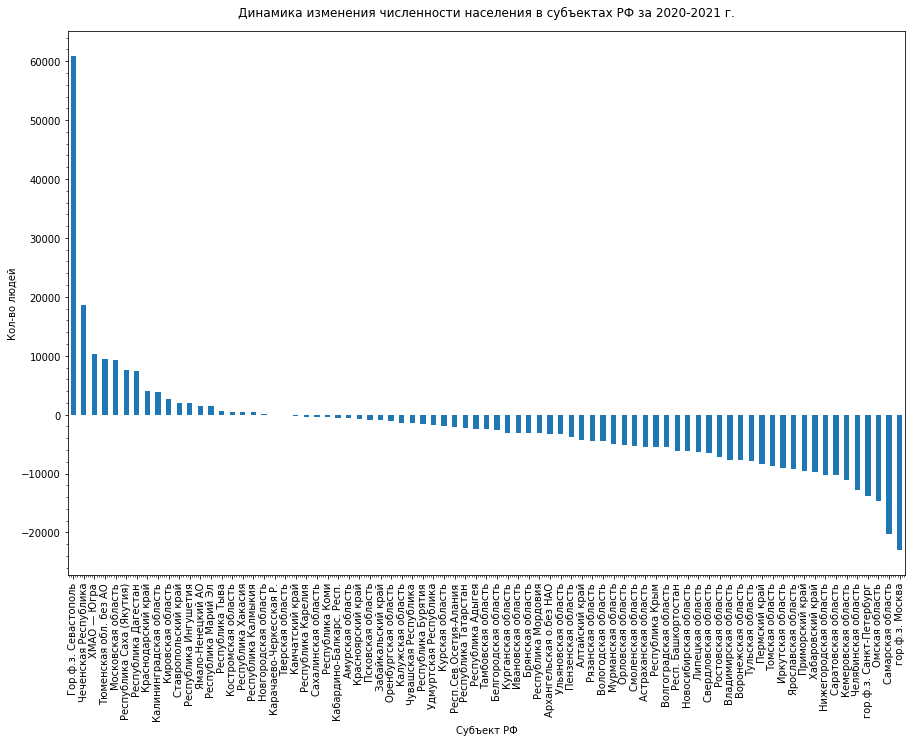

In [254]:
dyGraph = df.groupby('rfSubject').agg('sum').sort_values('Dynamics', ascending = False)[['Dynamics']]
plt.yticks([i for i in range(-20000, 60001, 10000)])
gr = dyGraph['Dynamics'].plot.bar(figsize = (15, 10))
gr.set_xlabel('Субъект РФ')
gr.set_ylabel('Кол-во людей')
gr.set_title(loc = 'center', pad = 15, label = "Динамика изменения численности населения в субъектах РФ за 2020-2021 г.")
plt.minorticks_on()